In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

fatal: destination path 'BIO-NER-' already exists and is not an empty directory.


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


# PREPROCESSING

In [ ]:
# External dependencies
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set3")
from matplotlib import pyplot as plt
import tensorflow as tf
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data

# For reproducibility
seed = 937
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Data in IOB format
file1 = "/content/drive/MyDrive/Data_Bio-NER/JNLPBA/original-data/train/Genia4ERtask1.iob2"
file2 = "/content/drive/MyDrive/Data_Bio-NER/JNLPBA/original-data/test/Genia4EReval1.iob2"

In [ ]:
# Read data from file
input_train = read_data(file1)
input_test = read_data(file2)

Total number of sentences: 18546 
Total number of sentences: 3856 


In [ ]:
# Instantiate an object for preprocessing
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)

In [ ]:
# Take a look to the data
print('This is what a sentence looks like:{}'.format(docs_train.data[0]))

This is what a sentence looks like:[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')]


In [ ]:
print("\033[1m"+"Statistics for the training set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the training set:
Number of sentences: 18546
Number of tokens: 492551
Size of vocabulary: 22056
Tagset: B-protein I-protein O B-cell_line I-cell_line I-RNA B-cell_type I-cell_type B-DNA B-RNA I-DNA
Number of Tags 11


# PREPROCESSING FOR TRAINING
<p style='text-align: justify;'>Before feeding the data to the model we need to further preprocess the text. It is important to ensure that all text should be of the same length. The method sequence **pad_sequences()** and variable *max_seq_len* are used for this purpose. The text which are shorter than fixed *max_seq_len* value are padded to get them to the same length, whereas text which are longer than *max_seq_len* are truncated. Then, we use the **TextVectorization** layer from tf as text encoder. This allows to transforms a sequences of strings into a list of token indices. Every token in a sequence is mapped to a corresponding integer ID. This saves a lot of memory.</p>

In [ ]:
max_seq_len = 50

In [ ]:
# Padding sentences to the max_seq_len
from keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_train.sentences, padding="post", value="", dtype=object, truncating = "post")
X_test_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_test.sentences, padding="post", value="", dtype=object, truncating = "post")

In [ ]:
# Check the padding
X_test_padded[812]

array(['Finally', ',', 'DR3/', 'Wsl-1', 'protein', 'expression', 'is',
       'quite', 'variable', 'among', 'these', 'NB', 'cell', 'lines', ',',
       'with', 'very', 'low', 'or', 'undetectable', 'levels', 'in', '7',
       'of', '17', 'NB', 'cell', 'lines', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype=object)

In [ ]:
# Mapping label to IDs and viceversa
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
tag2idx

{'B-DNA': 9,
 'B-RNA': 10,
 'B-cell_line': 4,
 'B-cell_type': 7,
 'B-protein': 1,
 'I-DNA': 11,
 'I-RNA': 6,
 'I-cell_line': 5,
 'I-cell_type': 8,
 'I-protein': 2,
 'O': 3,
 'PAD': 0}

In [ ]:
# Padding and encoding the target variable
y = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(split=None, standardize = None, ngrams=None, max_tokens=None, output_mode = "int")
encoder.adapt(docs_train.tokens)

In [ ]:
X_train = encoder(np.array(X_train_padded))
X_test = encoder(np.array(X_test_padded))

In [ ]:
# Extract vocabulary
voc = np.array(encoder.get_vocabulary())

In [ ]:
# Explore first 30 more frequent words in the train set, first entry reserved for PAD
voc[:30] 

array(['', '[UNK]', 'of', 'the', '.', ',', 'and', 'in', 'to', ')', '(',
       'a', 'cells', 'that', 'by', 'with', 'is', 'expression', 'was',
       'cell', 'for', 'B', 'The', 'T', 'gene', 'human', 'activation',
       'transcription', 'protein', 'as'], dtype='<U48')

In [ ]:
# A dict mapping words to their ID
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# A dict mapping IDs to their words
idx2word = {i: w for w, i in word_index.items()}

In [ ]:
word_index['']

0

In [ ]:
# Decoding in the test set; some words that are OOV are decoded as [UNK]
for n in range(3):
  print("Original: ", docs_test.sentences[n])
  print("Round-trip: ", " ".join(voc[X_test[n]]))
  print() 

Original:  ['Number', 'of', 'glucocorticoid', 'receptors', 'in', 'lymphocytes', 'and', 'their', 'sensitivity', 'to', 'hormone', 'action', '.']
Round-trip:  [UNK] of glucocorticoid receptors in lymphocytes and their sensitivity to hormone action .                                     

Original:  ['The', 'study', 'demonstrated', 'a', 'decreased', 'level', 'of', 'glucocorticoid', 'receptors', '(', 'GR', ')', 'in', 'peripheral', 'blood', 'lymphocytes', 'from', 'hypercholesterolemic', 'subjects', ',', 'and', 'an', 'elevated', 'level', 'in', 'patients', 'with', 'acute', 'myocardial', 'infarction', '.']
Round-trip:  The study demonstrated a decreased level of glucocorticoid receptors ( GR ) in peripheral blood lymphocytes from hypercholesterolemic subjects , and an elevated level in patients with acute myocardial infarction .                   

Original:  ['In', 'the', 'lymphocytes', 'with', 'a', 'high', 'GR', 'number', ',', 'dexamethasone', 'inhibited', '[', '3H', ']', '-thymidine', 'and', 

In [ ]:
# Check IDs 
print("The word 'cell' is identified by the index: {}".format(word_index["cell"]))
print("The labels 'B-DNA'(which defines the first token of a DNA entity) is identified by the index: {}".format(tag2idx["B-DNA"]))

The word 'cell' is identified by the index: 19
The labels 'B-DNA'(which defines the first token of a DNA entity) is identified by the index: 9


# IMPLEMENTING MODEL ARCHITECTURE

In [ ]:
# Hyperparams initialization
BATCH_SIZE = 32
EPOCHS = 20
EMBEDDING = 300

In [ ]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional, Input

In [ ]:
def double_bi_lstm_fun(lr = 0.001):
  input = Input(shape=(max_seq_len,), dtype="int32", name="Input") #timesteps
  model = Embedding(input_dim=len(word_index), output_dim=EMBEDDING,
                    input_length=max_seq_len, mask_zero = True, name="Embedding") (input)
  model = Dropout(0.5, name= "Dropout1") (model)
  model = Bidirectional(LSTM(units=100, return_sequences=True,
                    recurrent_dropout=0.2, name="LSTM1"), name= "Bi-LSTM1") (model)
  model = Dropout(0.5, name= "Dropout2") (model) 
  model = Bidirectional(LSTM(units=50, return_sequences=True,
                    recurrent_dropout=0.2, name="LSTM2"), name= "Bi-LSTM2") (model)
  out = Dense(len(tag2idx), activation="softmax", name= "Softmax") (model)

  model = Model(input, out, name= "Bi-LSTM_Softmax")

  model.compile(loss= "sparse_categorical_crossentropy",
                  optimizer=RMSprop(learning_rate=lr),
                  metrics=["accuracy"])
  return model

In [ ]:
# Build the model
model = double_bi_lstm_fun()

In [ ]:
model.summary()

Model: "Bi-LSTM_Softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 50)]              0         
_________________________________________________________________
Embedding (Embedding)        (None, 50, 300)           6617400   
_________________________________________________________________
Bi-LSTM1 (Bidirectional)     (None, 50, 200)           320800    
_________________________________________________________________
Bi-LSTM2 (Bidirectional)     (None, 50, 100)           100400    
_________________________________________________________________
Softmax (Dense)              (None, 50, 12)            1212      
Total params: 7,039,812
Trainable params: 7,039,812
Non-trainable params: 0
_________________________________________________________________


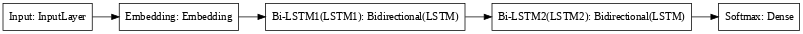

In [ ]:
tf.keras.utils.plot_model(model, rankdir="LR",dpi=54)

# EVALUATION METRICS

In [ ]:
dir_output = "/content/drive/MyDrive/BIO-NER-project/double-bi-lstm.h5"

In [ ]:
# Early stopping stops the training process when val_loss is not improving
# ModelCkpt save only the best model (model with lowest val_loss)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=1)
#model_save = ModelCheckpoint(dir_output, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  real_pred = []
  #pred = np.argmax(y_pred, -1) # Compute the label 
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

In [ ]:
%%capture
# Install seqeval library for evaluation score
!pip3 install seqeval

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation, training):   
        super(Metrics, self).__init__()
        self.validation = validation 
        self.training = training   
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.train_f1s = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = self.model.predict(self.validation[0])
        val_predict = np.argmax(val_predict, -1)
        y_true, y_hat = ignoring_padding(val_predict, val_targ)
        val_f1 = f1_score(y_true, y_hat, scheme=IOB2, mode="strict")
        train_targ = self.training[1]   
        train_predict = self.model.predict(self.training[0])
        train_predict = np.argmax(train_predict, -1)
        y_true_train, y_hat_train = ignoring_padding(train_predict, train_targ)
        train_f1 = f1_score(y_true_train, y_hat_train, scheme=IOB2, mode="strict")

        logs["val_f1"] = val_f1
        logs["train_f1"] = train_f1
        
        self.val_f1s.append(round(val_f1, 6))
        self.train_f1s.append(round(train_f1, 6))
         
        print(f' — val_f1: {val_f1} ')
        return

In [ ]:
X_train1 = tf.make_tensor_proto(X_train)
X_train = tf.make_ndarray(X_train1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size = 0.2, random_state = 276)

In [ ]:
# Customised callbacks
mycallbacks = [Metrics(validation=(X_val, y_val), training=(X_train, y_train)), early_stopping]

validation shape 3710


# TRAINING

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks = mycallbacks)

Epoch 1/20
464/464 [==============================] - 239s 491ms/step - loss: 0.4220 - accuracy: 0.7952 - val_loss: 0.1792 - val_accuracy: 0.8988
 — val_f1: 0.6265196204154913 
Epoch 2/20
464/464 [==============================] - 227s 489ms/step - loss: 0.1614 - accuracy: 0.9080 - val_loss: 0.1406 - val_accuracy: 0.9166
 — val_f1: 0.693847834000728 
Epoch 3/20
464/464 [==============================] - 226s 486ms/step - loss: 0.1136 - accuracy: 0.9301 - val_loss: 0.1389 - val_accuracy: 0.9131
 — val_f1: 0.7088432003963338 
Epoch 4/20
464/464 [==============================] - 225s 485ms/step - loss: 0.0971 - accuracy: 0.9406 - val_loss: 0.1315 - val_accuracy: 0.9233
 — val_f1: 0.731280724450194 
Epoch 5/20
464/464 [==============================] - 226s 486ms/step - loss: 0.0910 - accuracy: 0.9432 - val_loss: 0.1278 - val_accuracy: 0.9254
 — val_f1: 0.7389893370421883 
Epoch 6/20
464/464 [==============================] - 226s 486ms/step - loss: 0.0788 - accuracy: 0.9517 - val_loss: 0

# LEARNING CURVES

In [ ]:
epochs = len(history.epoch)
epochs = range(0,epochs)

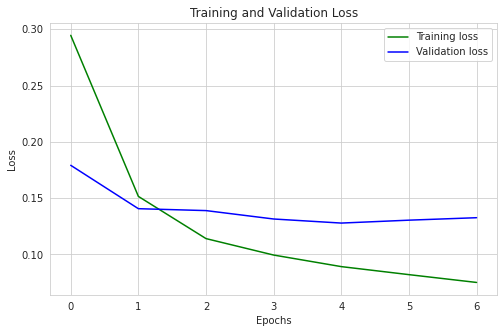

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["loss"]
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.xticks(np.arange(0, len(epochs)))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

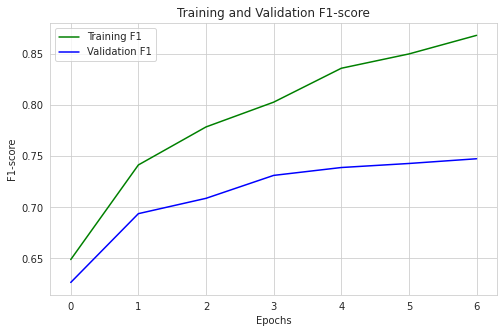

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history['train_f1']
loss_val = history.history['val_f1']
plt.plot(epochs, loss_train, 'g', label='Training F1')
plt.plot(epochs, loss_val, 'b', label='Validation F1')
plt.xticks(np.arange(0, len(epochs)))
plt.title('Training and Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

# REPORT

In [ ]:
%%capture
!pip install nervaluate

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.argmax(y_pred, -1)

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

In [ ]:
from nervaluate import Evaluator
golden_tags = ["protein", "cell_type", "cell_line", "DNA", "RNA"]
evaluator = Evaluator(y_true, y_hat, tags = golden_tags, loader="list")
results, results_by_tag = evaluator.evaluate()
import pandas as pd
res = pd.DataFrame.from_dict(results)

In [ ]:
res

,ent_type,partial,strict,exact
correct,6517.000000,5762.000000,5465.000000,5762.000000
incorrect,495.000000,0.000000,1547.000000,1250.000000
partial,0.000000,1250.000000,0.000000,0.000000
missed,1551.000000,1551.000000,1551.000000,1551.000000
spurious,2007.000000,2007.000000,2007.000000,2007.000000
possible,8563.000000,8563.000000,8563.000000,8563.000000
actual,9019.000000,9019.000000,9019.000000,9019.000000
precision,0.722586,0.708172,0.605943,0.638873
recall,0.761065,0.745883,0.638211,0.672895
f1,0.741326,0.726539,0.621659,0.655443


In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

         DNA       0.69      0.61      0.64      1037
         RNA       0.50      0.69      0.58       117
   cell_line       0.48      0.50      0.49       495
   cell_type       0.69      0.60      0.64      1890
     protein       0.64      0.66      0.65      5008

   micro avg       0.64      0.64      0.64      8547
   macro avg       0.60      0.61      0.60      8547
weighted avg       0.64      0.64      0.64      8547



In [ ]:
results_by_tag

{'DNA': {'ent_type': {'actual': 1084,
   'correct': 755,
   'f1': 0.7109227871939736,
   'incorrect': 117,
   'missed': 168,
   'partial': 0,
   'possible': 1040,
   'precision': 0.6964944649446494,
   'recall': 0.7259615384615384,
   'spurious': 212},
  'exact': {'actual': 1084,
   'correct': 716,
   'f1': 0.6741996233521658,
   'incorrect': 156,
   'missed': 168,
   'partial': 0,
   'possible': 1040,
   'precision': 0.6605166051660517,
   'recall': 0.6884615384615385,
   'spurious': 212},
  'partial': {'actual': 1084,
   'correct': 716,
   'f1': 0.7476459510357816,
   'incorrect': 0,
   'missed': 168,
   'partial': 156,
   'possible': 1040,
   'precision': 0.7324723247232472,
   'recall': 0.7634615384615384,
   'spurious': 212},
  'strict': {'actual': 1084,
   'correct': 639,
   'f1': 0.6016949152542372,
   'incorrect': 233,
   'missed': 168,
   'partial': 0,
   'possible': 1040,
   'precision': 0.5894833948339483,
   'recall': 0.614423076923077,
   'spurious': 212}},
 'RNA': {'ent_t

In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "micro",  scheme=IOB2, mode="strict")))

F1-score: 0.638


# COMPARE RESULTS

In [ ]:
i = 18

In [ ]:
# From tensor to array
X_test1 = tf.make_tensor_proto(X_test)
X_test1 = tf.make_ndarray(X_test1)

In [ ]:
# Compare results
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_test1[i], y_true[i], y_hat[i]):
  print("{:15}:{:15} ({})".format(idx2word[w], pred, true))

Word            Pred : (True)
However        :O               (O)
,              :O               (O)
there          :O               (O)
was            :O               (O)
a              :O               (O)
significantly  :O               (O)
positive       :O               (O)
association    :O               (O)
between        :O               (O)
tumor          :O               (B-protein)
beta           :O               (I-protein)
[UNK]          :O               (I-protein)
expression     :O               (O)
and            :O               (O)
the            :O               (O)
degree         :O               (O)
of             :O               (O)
lymphocytic    :O               (O)
infiltration   :O               (O)
in             :O               (O)
the            :O               (O)
tumor          :O               (O)
tissue         :O               (O)
.              :O               (O)
